In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import numpy as np
import lineagevi
from lineagevi.utils import *
import torch

In [3]:
adata = sc.read_h5ad('/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.17_12.43.17/adata_with_velocity.h5ad')

In [4]:
adata.layers['velocity'] *=-1
adata.obsm['velocity_gp'] *=-1

computing velocity graph (using 1/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


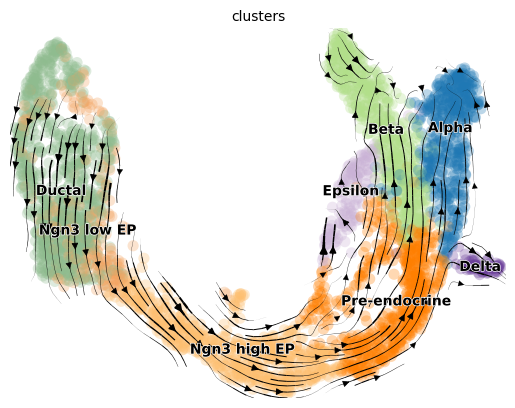

In [5]:
sc.pp.neighbors(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters')

computing velocity graph (using 1/10 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


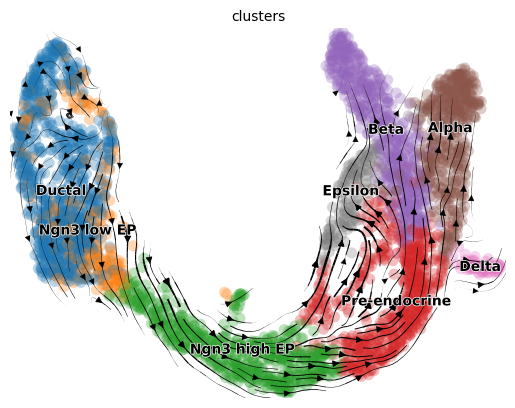

In [6]:
adata_gp = sc.AnnData(X=adata.obsm['z'])

adata_gp.obs = adata.obs.copy()
adata_gp.var_names = adata.uns['terms']
adata_gp.layers['velocity'] = adata.obsm['velocity_gp']
adata_gp.layers['spliced'] = adata.obsm['z']
adata_gp.obsm['X_umap'] = adata.obsm['X_umap']

sc.pp.neighbors(adata_gp)
scv.tl.velocity_graph(adata_gp)
scv.pl.velocity_embedding_stream(adata_gp, color='clusters')

computing velocity graph (using 1/10 cores)
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


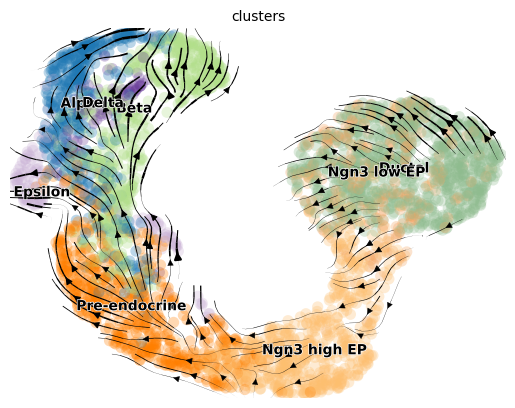

In [7]:
sc.pp.neighbors(adata, use_rep='z')
sc.tl.umap(adata)
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color='clusters')

computing velocity graph (using 1/10 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


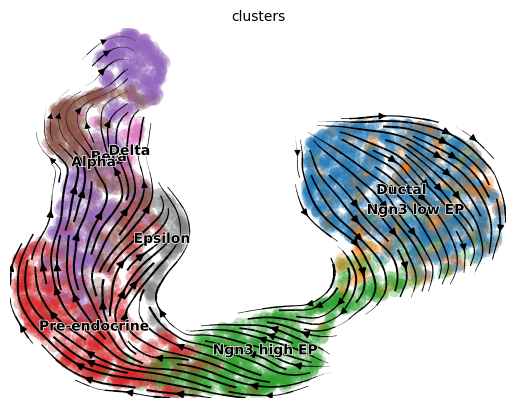

In [8]:
sc.pp.neighbors(adata_gp)
sc.tl.umap(adata_gp)
scv.tl.velocity_graph(adata_gp)
scv.pl.velocity_embedding_stream(adata_gp, color='clusters')

In [9]:
adata

AnnData object with n_obs × n_vars = 3696 × 1805
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'indices', 'log1p', 'neighbors', 'pca', 'terms', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'umap'
    obsm: 'X_pca', 'X_umap', 'velocity_gp', 'z', 'velocity_umap'
    varm: 'I', 'PCs'
    layers: 'Ms', 'Mu', 'recon', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

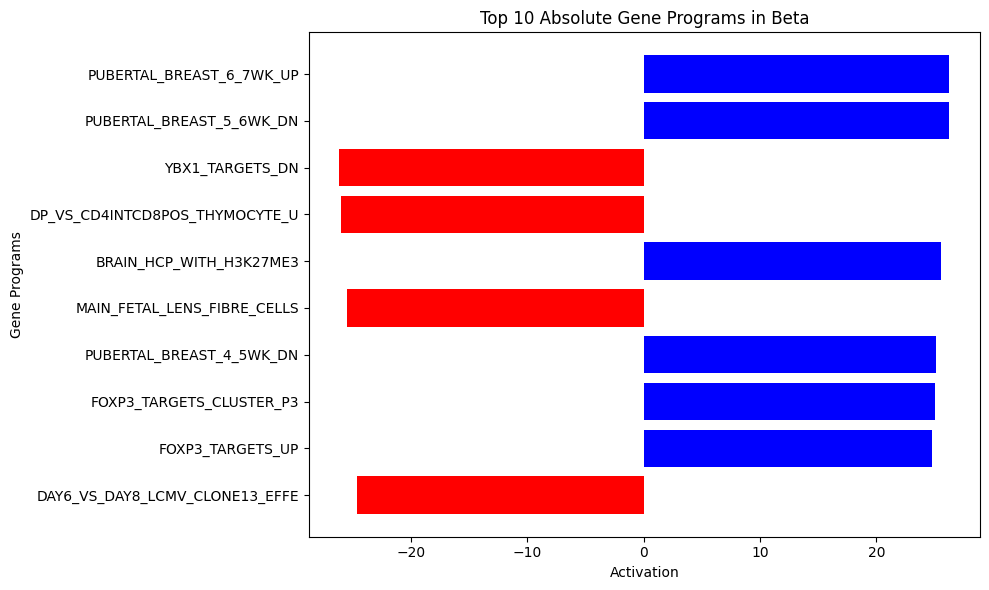

In [10]:
plot_top_gps_per_celltype(adata,
                        groupby="clusters", 
                        latent_key="z",
                        term_key="terms",
                        n=10,
                        target_group='Beta')

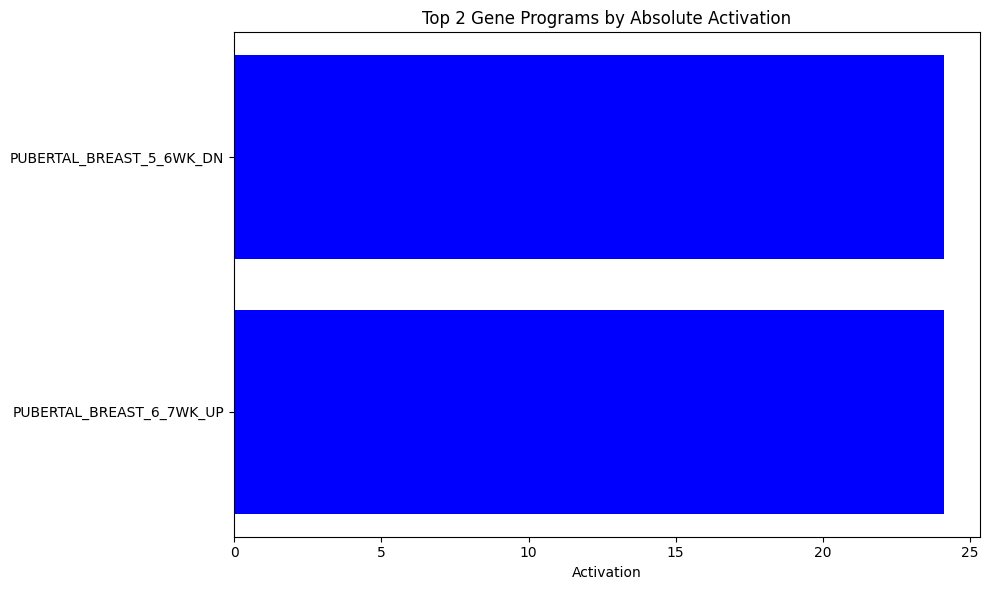

In [11]:
plot_top_gps_activation(adata, latent_key="z", terms_key="terms", n=2)

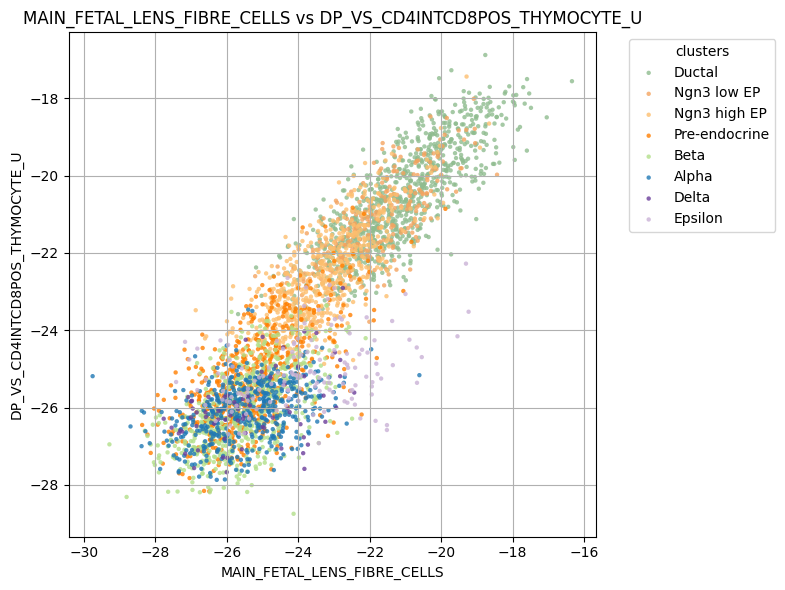

In [12]:
term_x = 'MAIN_FETAL_LENS_FIBRE_CELLS'
term_y = 'DP_VS_CD4INTCD8POS_THYMOCYTE_U'
scatter_terms(adata,
                term_x, 
                term_y, 
                latent_key="z", 
                term_key="terms", 
                groupby="clusters",
                s=10,
                alpha=0.8)

In [ ]:
model = lineageVIModel(
    adata,
    n_hidden=128,
    mask_key='I',
    gene_prior=True,
    seed=0
)

model.eval()

NameError: name 'lineageVIModel' is not defined

In [ ]:
adata.X.data

array([0.8110648, 0.8110648, 2.8480403, ..., 0.7158527, 0.7158527,
       1.1287732], dtype=float32)

In [ ]:
unspliced = torch.tensor(adata.layers['unspliced'].toarray())
spliced = torch.tensor(adata.layers['spliced'].toarray())
x = torch.concatenate([unspliced, spliced], dim=1)
x.shape

torch.Size([3696, 3610])

In [ ]:
z, mean, logvar = model.encoder(x)

RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA_addmm)

In [ ]:
def forward_encoder(model, x):
    z, mean, logvar = model.encoder(x)
    return z, mean, logvar

z, mean, logvar = forward_encoder(model, x)

'''def sample_z(model, x, n_samples):
    _, mean, logvar = forward_encoder(x)
    for sample in range(n_samples):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std'''

def forward_gene_decoder(model, z):
    x_rec = model.gene_decoder(z)
    return x_rec

x_rec = forward_gene_decoder(model, z)

def forward_velocity_decoder(model, z, x):
    velocity, velocity_u = model.velocity_decoder(z, x)
    return velocity, velocity_u

velocity, velocity_u = forward_velocity_decoder(model, z, x)

In [ ]:
mean

tensor([[ 0.6318, -0.5221,  0.0666,  ..., -0.5866,  0.2669,  0.1930],
        [ 0.3796, -0.2216, -0.2513,  ..., -0.2330, -0.0103, -0.1220],
        [ 0.5402, -0.2992,  0.0428,  ..., -0.3005,  0.3624, -0.0190],
        ...,
        [ 0.3760, -0.3838, -0.2015,  ..., -0.2958,  0.1146, -0.2238],
        [ 0.1096, -0.3949, -0.1451,  ..., -0.3549,  0.2251, -0.2836],
        [ 0.4251, -0.3928, -0.0842,  ...,  0.0106,  0.4282,  0.0886]],
       grad_fn=<AddmmBackward0>)